In [2]:
!pip install roboflow -q

In [3]:
# WARNING: This auto-labels data using MediaPipe hand detection (useful if you don't already have bbox labels).
# It saves labels in YOLO format (class_index x_center y_center width height) normalized [0..1].

import mediapipe as mp
import cv2
from pathlib import Path
from tqdm import tqdm

DATASET_ROOT = Path(r"C:\Users\rudra\coding\AIML\DeepLearning\Real-Time-ASL-Detection\ASL_MERGED")  # change if needed
OUT_YOLO = Path("asl_yolo_autolabel")  # output dataset with images and labels
OUT_YOLO.mkdir(exist_ok=True)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# We'll create train/images, train/labels, val/images, val/labels using your existing train/test split
for split in ["train", "test"]:
    images_out = OUT_YOLO / split / "images"
    labels_out = OUT_YOLO / split / "labels"
    images_out.mkdir(parents=True, exist_ok=True)
    labels_out.mkdir(parents=True, exist_ok=True)
    src_split = DATASET_ROOT / split
    if not src_split.exists():
        print("Missing split:", src_split)
        continue
    for cls in tqdm(list(src_split.iterdir()), desc=f"Processing {split}"):
        if not cls.is_dir():
            continue
        cls_name = cls.name
        # class index mapping: map class letter -> numeric index (you can define mapping)
        # Create a consistent mapping file later (data.yaml)
        for imf in cls.glob("*"):
            if imf.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
                continue
            img = cv2.imread(str(imf))
            if img is None:
                continue
            h, w = img.shape[:2]
            # run mediapipe
            image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = hands.process(image_rgb)
            if results.multi_hand_landmarks:
                # compute bounding box of landmarks
                all_x = []
                all_y = []
                for lm in results.multi_hand_landmarks[0].landmark:
                    all_x.append(lm.x)
                    all_y.append(lm.y)
                x_min = max(0, min(all_x))
                x_max = min(1, max(all_x))
                y_min = max(0, min(all_y))
                y_max = min(1, max(all_y))
                # convert to pixel coords
                x1 = int(x_min * w)
                x2 = int(x_max * w)
                y1 = int(y_min * h)
                y2 = int(y_max * h)
                # expand bbox slightly to include whole hand
                pad_w = int((x2 - x1) * 0.2)
                pad_h = int((y2 - y1) * 0.2)
                x1 = max(0, x1 - pad_w); x2 = min(w, x2 + pad_w)
                y1 = max(0, y1 - pad_h); y2 = min(h, y2 + pad_h)
                # YOLO normalized format
                x_center = ((x1 + x2) / 2) / w
                y_center = ((y1 + y2) / 2) / h
                bw = (x2 - x1) / w
                bh = (y2 - y1) / h
                # define numeric class index for letter
                # we will use mapping A->0, B->1, ... Z->25, plus handle 'Blank' or others if present
                if cls_name.upper() == "BLANK":  # optional mapping for blank
                    class_idx = 26
                else:
                    class_idx = ord(cls_name.upper()[0]) - ord("A")
                # Save image to output images
                out_img = images_out / imf.name
                cv2.imwrite(str(out_img), img)
                # Save label
                lbl_path = labels_out / (imf.stem + ".txt")
                with open(lbl_path, "w") as f:
                    f.write(f"{class_idx} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}\n")
            else:
                # no hand detected: skip or optionally save as no-label
                pass

print("Auto-labeling complete. Check", OUT_YOLO)


Processing test: 100%|██████████| 27/27 [01:16<00:00,  2.82s/it]

Auto-labeling complete. Check asl_yolo_autolabel


In [ ]:
from pathlib import Path
out = Path("asl_yolo_autolabel")  # or your roboflow downloaded folder
train_images = str(out / "train" / "images")
val_images = str(out / "test" / "images")

# Define class names in order (A..Z + maybe Blank)
CLASS_NAMES = [chr(i) for i in range(65, 91)]  # A-Z
# If you have a 'Blank' class add it after:
# CLASS_NAMES.append("Blank")

data_yaml = {
    "names": CLASS_NAMES,
    "nc": len(CLASS_NAMES),
    "train": train_images,
    "val": val_images
}

import yaml
with open("data.yaml", "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)
print("Created data.yaml:", Path("data.yaml").resolve())


Created data.yaml: C:\Users\rudra\coding\AIML\DeepLearning\Real-Time-ASL-Detection\data.yaml


In [1]:
# Using Ultralytics Python API for YOLOv8 training
from ultralytics import YOLO

# choose a backbone: 'yolov8n.pt' (nano), 'yolov8s.pt' (small), 'yolov8m.pt' (medium) depending on GPU
MODEL_BACKBONE = "yolov8n.pt"  # change to yolov8n.pt for faster experimentation

# Create and train model
model = YOLO(MODEL_BACKBONE)  # loads pretrained weights

# Train: adjust epochs and batch size per your GPU


c:\Users\rudra\.conda\envs\blackwell\lib\site-packages\torch\cuda\__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
model.train(
    data="data.yaml",
    epochs=30,
    imgsz=512,     # lighter than 640
    batch=16,       # safe for 12GB VRAM
    workers=4,
    half=True,
    name="asl_yolo_nano"
)

New https://pypi.org/project/ultralytics/8.3.234 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.222  Python-3.10.19 torch-2.10.0.dev20251030+cu130 CUDA:0 (NVIDIA GeForce RTX 5070 Ti Laptop GPU, 12227MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=True, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=asl_yolo_nano3, 

KeyboardInterrupt: 

In [1]:
# Jupyter-friendly webcam + MediaPipe + YOLO display
# Paste into one notebook cell and run.
import threading, time, io
import cv2
import mediapipe as mp
from ultralytics import YOLO
import numpy as np
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

# ---- load your model (change path as needed) ----
yolo_weights = r"./runs/detect/asl_yolo_nano3/weights/best.pt"
yolo = YOLO(yolo_weights)

# ---- MediaPipe setup ----
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# NOTE: create Hands instance inside thread or reuse carefully
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# ---- classification function (your existing logic) ----
def classify_frame_with_mediapipe(frame):
    h, w = frame.shape[:2]
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    res = hands.process(rgb)
    preds = []
    if res.multi_hand_landmarks:
        for hand_landmarks in res.multi_hand_landmarks:
            xs = [lm.x for lm in hand_landmarks.landmark]
            ys = [lm.y for lm in hand_landmarks.landmark]
            x1 = int(max(0, min(xs) * w - 0.05*w))
            x2 = int(min(w, max(xs) * w + 0.05*w))
            y1 = int(max(0, min(ys) * h - 0.05*h))
            y2 = int(min(h, max(ys) * h + 0.05*h))
            crop = frame[y1:y2, x1:x2]
            if crop.size == 0:
                continue
            # Run YOLO inference on crop
            res_yolo = yolo.predict(source=crop, conf=0.25, verbose=False)
            boxes = res_yolo[0].boxes
            if len(boxes) > 0:
                top = boxes.data[0]    # [x1,y1,x2,y2,conf,cls] (Ultralytics typical ordering)
                # Some versions place class last; keep guarded:
                if top.shape[0] >= 6:
                    cls_idx = int(top[5].item())
                    conf = float(top[4].item())
                else:
                    cls_idx = int(top[-1].item())
                    conf = float(top[-2].item())
                preds.append({"class_idx": cls_idx, "conf": conf, "bbox": (x1,y1,x2,y2)})
            else:
                preds.append({"class_idx": None, "conf": 0.0, "bbox": (x1,y1,x2,y2)})
    return preds

# ---- UI widget ----
image_widget = widgets.Image(format='jpeg', width=640, height=480)
start_btn = widgets.Button(description="Start", button_style='success')
stop_btn  = widgets.Button(description="Stop", button_style='danger')
status_label = widgets.Label(value="Ready")

ui = widgets.HBox([start_btn, stop_btn, status_label])
display(ui)
display(image_widget)

# ---- thread control ----
_stop_event = threading.Event()
_capture_thread = None

def _frame_to_jpeg_bytes(frame):
    # Convert BGR -> RGB -> JPEG bytes
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    buff = io.BytesIO()
    pil.save(buff, format='JPEG', quality=70)
    return buff.getvalue()

def _capture_loop():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        status_label.value = "Error: cannot open webcam"
        return
    status_label.value = "Running..."
    frame_idx = 0
    try:
        while not _stop_event.is_set():
            ret, frame = cap.read()
            if not ret:
                status_label.value = "Frame read failed"
                break

            # Run mediapipe + yolo and draw annotations
            try:
                preds = classify_frame_with_mediapipe(frame)
            except Exception as e:
                # protect loop from occasional inference errors
                preds = []
                # you can log e if needed
            for p in preds:
                x1,y1,x2,y2 = p["bbox"]
                cls = p["class_idx"]
                conf = p["conf"]
                label = f"{chr(65+cls)} {conf:.2f}" if cls is not None else "Unknown"
                cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
                cv2.putText(frame, label, (max(0,x1), max(10,y1-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

            # Update widget
            image_widget.value = _frame_to_jpeg_bytes(frame)
            frame_idx += 1

            # tiny sleep to yield to notebook (tune if needed)
            time.sleep(0.02)

    finally:
        # cleanup
        try:
            cap.release()
        except Exception:
            pass
        status_label.value = "Stopped"

def start_capture(_=None):
    global _capture_thread, _stop_event
    if _capture_thread and _capture_thread.is_alive():
        status_label.value = "Already running"
        return
    _stop_event.clear()
    _capture_thread = threading.Thread(target=_capture_loop, daemon=True)
    _capture_thread.start()

def stop_capture(_=None):
    _stop_event.set()

start_btn.on_click(start_capture)
stop_btn.on_click(stop_capture)


c:\Users\rudra\.conda\envs\blackwell\lib\site-packages\torch\cuda\__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Image(value=b'', format='jpeg', height='480', width='640')

In [1]:
# Batch-per-task joblib version (Jupyter-friendly)
from joblib import Parallel, delayed, cpu_count
from pathlib import Path
import cv2, mediapipe as mp, numpy as np
from tqdm.auto import tqdm

DATASET_ROOT = Path(r"C:\Users\rudra\coding\AIML\DeepLearning\Real-Time-ASL-Detection\ASL_MERGED")
ALLOWED_EXT = {".jpg", ".jpeg", ".png"}
RESIZE_TO = (640, 480)
MIN_CONF = 0.5

def iter_image_label_pairs(root: Path):
    for split in ["train", "test"]:
        split_dir = root / split
        if not split_dir.exists():
            continue
        for cls in sorted(split_dir.iterdir()):
            if not cls.is_dir():
                continue
            cls_idx = ord(cls.name.upper()[0]) - ord("A")
            for imgf in cls.iterdir():
                if imgf.suffix.lower() in ALLOWED_EXT:
                    yield imgf, cls_idx

def process_batch(batch, resize_to=None, min_det_conf=MIN_CONF):
    """
    batch: list of (Path, label)
    returns list of results like (feat, label) or ("FAILED", path, reason)
    """
    mp_hands = mp.solutions.hands
    out = []
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=min_det_conf) as hands:
        for img_path, label in batch:
            img = cv2.imread(str(img_path))
            if img is None:
                out.append(("FAILED", str(img_path), "imread_failed"))
                continue
            if resize_to:
                img = cv2.resize(img, resize_to)
            rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            res = hands.process(rgb)
            if res and res.multi_hand_landmarks:
                lm = res.multi_hand_landmarks[0]
                feat = []
                for l in lm.landmark:
                    feat.extend([l.x, l.y, l.z])
                out.append((feat, label))
            else:
                out.append(("FAILED", str(img_path), "no_landmarks"))
    return out

# prepare pairs and form batch-list for workers
pairs = list(iter_image_label_pairs(DATASET_ROOT))
print("Total images:", len(pairs))

BATCH_SIZE = 256   # tune: 128-1024 depending on memory
batches = [pairs[i:i+BATCH_SIZE] for i in range(0, len(pairs), BATCH_SIZE)]
print("Total batches:", len(batches))

n_jobs = max(1, cpu_count() - 20)  # keep some cores free
print("Using n_jobs=", n_jobs)

# run in parallel: each job gets a whole batch and creates a single Hands instance
results = Parallel(n_jobs=n_jobs, backend="loky")(
    delayed(process_batch)(batch, RESIZE_TO, MIN_CONF) for batch in tqdm(batches)
)

# flatten results
flat = [item for sub in results for item in sub]

# separate successes/failures (same as before)
X_list, y_list, failed = [], [], []
for r in flat:
    if isinstance(r, tuple) and r and r[0] == "FAILED":
        failed.append((r[1], r[2]))
    else:
        feat, lbl = r
        X_list.append(feat); y_list.append(lbl)

print("Extracted:", len(X_list), "Failed:", len(failed))


Total images: 114000
Total batches: 446
Using n_jobs= 12


  0%|          | 0/446 [00:00<?, ?it/s]

Extracted: 86864 Failed: 27136


In [13]:
# Cell 1: Train RF from cached features or in-memory X_list,y_list and save model
# Run this cell to train and save landmark_classifier.joblib

import os, sys
import numpy as np
import joblib
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

# Configuration
CACHE_FILE = Path("landmark_features.npz")   # optional cache of features (X,y)
OUTPUT_RF = Path("landmark_classifier.joblib")
RANDOM_STATE = 42
TEST_SIZE = 0.15

# Try to load cached features first
if CACHE_FILE.exists():
    print("Loading cached features from", CACHE_FILE)
    arr = np.load(CACHE_FILE)
    X = arr["X"]
    y = arr["y"]
else:
    # fallback: check if X_list / y_list exist in global namespace (from earlier cell)
    if "X_list" in globals() and "y_list" in globals():
        print("Using X_list / y_list from notebook memory")
        X = np.array(X_list, dtype=np.float32)
        y = np.array(y_list, dtype=np.int32)
    else:
        raise FileNotFoundError(
            "No cached features found and X_list/y_list not in memory.\n"
            "Run the landmark extraction cell first (the batch-per-task extraction), or save features to 'landmark_features.npz'."
        )

print("Shape X:", X.shape, "y:", y.shape)
print("Class distribution:", Counter(y))

# Train/Val split (safe fallback if stratify fails)
try:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
except Exception as e:
    print("Stratified split failed (likely class imbalance). Doing random split.")
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=None)

print("Train samples:", X_train.shape[0], "Val samples:", X_val.shape[0])

# Train RandomForest
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE)
print("Training RandomForest...")
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {acc:.4f}")
print("Classification report:")
print(classification_report(y_val, y_pred, zero_division=0))

# Save model
joblib.dump(clf, OUTPUT_RF)
print("Saved RF model to", OUTPUT_RF)

# Optionally re-save features for later runs
np.savez_compressed(CACHE_FILE, X=X, y=y)
print("Saved feature cache to", CACHE_FILE)


Using X_list / y_list from notebook memory
Shape X: (86864, 63) y: (86864,)
Class distribution: Counter({3: 4730, 18: 4600, 6: 3700, 10: 3694, 5: 3626, 22: 3606, 9: 3581, 21: 3480, 7: 3462, 17: 3447, 24: 3403, 20: 3351, 8: 3289, 16: 3246, 14: 3203, 25: 3196, 11: 3164, 19: 3157, 4: 3122, 1: 3110, 2: 3054, 23: 3009, 0: 2975, 15: 2897, 12: 2641, 13: 2121})
Train samples: 73834 Val samples: 13030
Training RandomForest...
Validation accuracy: 0.9873
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       446
           1       1.00      1.00      1.00       467
           2       0.99      1.00      1.00       458
           3       0.99      0.98      0.98       710
           4       1.00      1.00      1.00       468
           5       0.99      0.99      0.99       544
           6       0.98      1.00      0.99       555
           7       1.00      0.98      0.99       519
           8       1.00      0.99      0.

In [14]:
# Cell 2: Optional — compare YOLO vs RF on test images (image-level)
# WARNING: may be slow if many images. Runs MediaPipe once per image.

from ultralytics import YOLO
import cv2
import mediapipe as mp
import numpy as np
from pathlib import Path
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib, json

# Config — change paths if needed
YOLO_WEIGHTS = "./runs/detect/asl_yolo_nano3/weights/best.pt"  # change if different
RF_MODEL = "landmark_classifier.joblib"
TEST_ROOT = Path(r"C:\Users\rudra\coding\AIML\DeepLearning\Real-Time-ASL-Detection\ASL_MERGED\test")

# Load models
print("Loading YOLO (may take a second)...")
yolo = YOLO(YOLO_WEIGHTS)
clf = joblib.load(RF_MODEL)
print("Loaded RF from", RF_MODEL)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

gt = []
yolo_preds = []
rf_preds = []

NO_DET = -1  # we'll mark missed detections as -1

for cls in sorted(TEST_ROOT.iterdir()):
    if not cls.is_dir(): continue
    gt_cls = ord(cls.name.upper()[0]) - ord("A")
    for imf in cls.iterdir():
        if imf.suffix.lower() not in [".jpg",".png",".jpeg"]: continue
        img = cv2.imread(str(imf))
        if img is None: continue

        # YOLO prediction (take top box if any)
        r = yolo.predict(source=img, conf=0.25, imgsz=512, verbose=False)[0]
        if r.boxes is not None and len(r.boxes) > 0:
            # choose highest-conf box
            try:
                conf = r.boxes.conf.cpu().numpy().ravel()
                cls_idxs = r.boxes.cls.cpu().numpy().ravel().astype(int)
                best = int(np.argmax(conf))
                yolo_pred = int(cls_idxs[best])
            except Exception:
                data = r.boxes.data.cpu().numpy()
                best = int(np.argmax(data[:,4]))
                yolo_pred = int(data[best,5])
        else:
            yolo_pred = NO_DET

        # RF prediction via MediaPipe on full frame (if landmarks found)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)
        if res and res.multi_hand_landmarks:
            lm = res.multi_hand_landmarks[0]
            feat = [v for p in lm.landmark for v in (p.x, p.y, p.z)]
            X = np.array(feat, dtype=np.float32).reshape(1,-1)
            rf_pred = int(clf.predict(X)[0])
        else:
            rf_pred = NO_DET

        gt.append(gt_cls)
        yolo_preds.append(yolo_pred)
        rf_preds.append(rf_pred)

# Convert to arrays and print simple reports (skipping NO_DET where appropriate)
import numpy as np
gt = np.array(gt)
yolo_preds = np.array(yolo_preds)
rf_preds = np.array(rf_preds)

# Evaluate only where RF produced a prediction
mask_rf = rf_preds != NO_DET
if mask_rf.sum() > 0:
    print("RF accuracy on images where MP found landmarks:", accuracy_score(gt[mask_rf], rf_preds[mask_rf]))
    print(classification_report(gt[mask_rf], rf_preds[mask_rf], zero_division=0))
else:
    print("RF made no predictions (MediaPipe failed on all images)")

# Evaluate YOLO where it predicted
mask_y = yolo_preds != NO_DET
if mask_y.sum() > 0:
    print("YOLO accuracy (images with detection):", accuracy_score(gt[mask_y], yolo_preds[mask_y]))
    print(classification_report(gt[mask_y], yolo_preds[mask_y], zero_division=0))
else:
    print("YOLO made no predictions (unexpected)")

# Cleanup
hands.close()


Loading YOLO (may take a second)...
Loaded RF from landmark_classifier.joblib
RF accuracy on images where MP found landmarks: 0.9935539321014182
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        92
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        92
           3       0.96      1.00      0.98        82
           4       1.00      0.97      0.99        76
           5       1.00      1.00      1.00        90
           6       0.99      1.00      0.99        98
           7       1.00      1.00      1.00        97
           8       1.00      1.00      1.00        91
           9       1.00      0.99      0.99        91
          10       0.98      1.00      0.99        92
          11       1.00      1.00      1.00        93
          12       0.99      1.00      0.99        85
          13       1.00      1.00      1.00        93
          14       1.00      1.00      1.00 

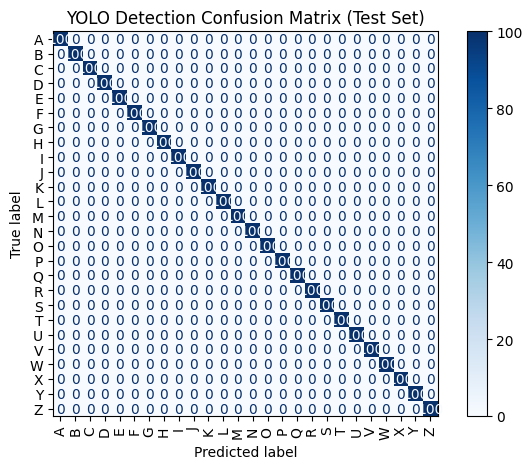

In [15]:
from collections import defaultdict
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ultralytics import YOLO
import matplotlib.pyplot as plt
# Load trained YOLO
yolo = YOLO("./runs/detect/asl_yolo_nano3/weights/best.pt")

# iterate test images and collect predictions vs labels
gt = []
preds = []

test_root = Path(r"C:\Users\rudra\coding\AIML\DeepLearning\Real-Time-ASL-Detection\ASL_MERGED\test")
class_map = {chr(i): i-65 for i in range(65,91)}  # 'A':0...

for cls in sorted(test_root.iterdir()):
    if not cls.is_dir():
        continue
    cls_idx = ord(cls.name.upper()[0]) - ord("A")
    for imf in cls.iterdir():
        if imf.suffix.lower() not in [".jpg",".png",".jpeg"]:
            continue
        img = cv2.imread(str(imf))
        if img is None:
            continue
        # simple approach: run yolo on full image and take top class prediction (if any)
        r = yolo.predict(source=img, conf=0.25, verbose=False)
        if len(r[0].boxes) > 0:
            top = r[0].boxes.data[0]
            pred_cls = int(top[5].item())
        else:
            pred_cls = -1  # no pred
        gt.append(cls_idx)
        preds.append(pred_cls)

# filter out images where pred == -1 as needed or include as 'no-detection'
labels = list(range(26))
cm = confusion_matrix(gt, preds, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[chr(i) for i in range(65,91)])
disp.plot(xticks_rotation=90, cmap="Blues")
plt.title("YOLO Detection Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


In [7]:
# Using ultralytics export command
model = YOLO("./runs/detect/asl_yolo_nano3//weights/best.pt")
model.export(format="onnx")  # outputs best.onnx
# for tflite: model.export(format="tflite")


Ultralytics 8.3.222  Python-3.10.19 torch-2.10.0.dev20251030+cu130 CPU (AMD Ryzen 9 8940HX with Radeon Graphics)
Model summary (fused): 72 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs\detect\asl_yolo_nano3\weights\best.pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 30, 5376) (11.8 MB)

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.72...
ONNX: export success  3.2s, saved as 'runs\detect\asl_yolo_nano3\weights\best.onnx' (11.7 MB)

Export complete (3.4s)
Results saved to C:\Users\rudra\coding\AIML\DeepLearning\Real-Time-ASL-Detection\runs\detect\asl_yolo_nano3\weights
Predict:         yolo predict task=detect model=runs\detect\asl_yolo_nano3\weights\best.onnx imgsz=512  
Validate:        yolo val task=detect model=runs\detect\asl_yolo_nano3\weights\best.onnx imgsz=512 data=data.yaml  
Visualize:       https://netron.app


'runs\\detect\\asl_yolo_nano3\\weights\\best.onnx'

In [9]:
from ultralytics import YOLO
model = YOLO("./runs/detect/asl_yolo_nano3/weights/best.pt")
# Validate against data.yaml to get mAP/precision/recall
results = model.val(data="data.yaml", imgsz=512, batch=16)
print(results)   # prints mAP, P, R etc.


Ultralytics 8.3.222  Python-3.10.19 torch-2.10.0.dev20251030+cu130 CUDA:0 (NVIDIA GeForce RTX 5070 Ti Laptop GPU, 12227MiB)
Model summary (fused): 72 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 960.5938.4 MB/s, size: 256.5 KB)
val: Scanning C:\Users\rudra\coding\AIML\DeepLearning\Real-Time-ASL-Detection\asl_yolo_autolabel\test\labels.cache... 2327 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2327/2327  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 146/146 11.1it/s 13.2s0.2s
                   all       2327       2327      0.992      0.994      0.993      0.907
                     A         92         92      0.998          1      0.995      0.921
                     B         89         89      0.996          1      0.995      0.914
                     C         92         92      0.996          1      0.995      0.941
                     D         82

In [1]:
# Realtime YOLO + MediaPipe + RF (Jupyter-safe single cell)
import threading, time, io, sys
import cv2
import numpy as np
from PIL import Image
import joblib
import mediapipe as mp
from ultralytics import YOLO
import ipywidgets as widgets
from IPython.display import display, clear_output

# -----------------------
# CONFIG - edit if needed
# -----------------------
YOLO_WEIGHTS = "./runs/detect/asl_yolo_nano3/weights/best.pt"   # your YOLO .pt
RF_MODEL = "./landmark_classifier.joblib"                      # saved RF
IMG_SZ = 640                       # YOLO input size
YOLO_CONF = 0.25         # detection threshold for YOLO inference
YOLO_HIGH_CONF = 0.85    # accept YOLO only-if-no-MP and conf >= this
PAD_RATIO = 0.12         # padding around MP bbox when cropping for RF
MIN_CROP_SIDE = 128      # minimum side for crop (scaled up if smaller)
IOU_THRESH = 0.25        # IoU threshold to match YOLO box to MP hand box
MP_MIN_CONF = 0.35       # MediaPipe min_detection_confidence (lower = more sensitive)
SHOW_FPS = True

# -----------------------
# Load models (may take a few seconds)
# -----------------------
print("Loading YOLO model (may take a moment)...")
yolo = YOLO(YOLO_WEIGHTS)
print("Loading RF model...")
clf = joblib.load(RF_MODEL)
print("Models loaded.")

# Create a single MediaPipe Hands instance for reuse
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=MP_MIN_CONF)

# -----------------------
# Helpers
# -----------------------
def _frame_to_jpeg_bytes(frame_bgr, quality=70):
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    buff = io.BytesIO()
    pil.save(buff, format='JPEG', quality=quality)
    return buff.getvalue()

def iou(boxA, boxB):
    # box: (x1,y1,x2,y2)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = max(0, boxA[2]-boxA[0]) * max(0, boxA[3]-boxA[1])
    boxBArea = max(0, boxB[2]-boxB[0]) * max(0, boxB[3]-boxB[1])
    union = boxAArea + boxBArea - interArea
    return interArea / union if union > 0 else 0.0

def normalize_landmarks(hand_lm):
    """Normalize landmarks relative to hand bounding box (0-1 range)"""
    xs = [lm.x for lm in hand_lm.landmark]
    ys = [lm.y for lm in hand_lm.landmark]
    zs = [lm.z for lm in hand_lm.landmark]
    
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    z_min, z_max = min(zs), max(zs)
    
    # Avoid division by zero
    x_range = max(x_max - x_min, 1e-6)
    y_range = max(y_max - y_min, 1e-6)
    z_range = max(z_max - z_min, 1e-6)
    
    normalized = []
    for lm in hand_lm.landmark:
        norm_x = (lm.x - x_min) / x_range
        norm_y = (lm.y - y_min) / y_range
        norm_z = (lm.z - z_min) / z_range
        normalized.extend([norm_x, norm_y, norm_z])
    
    return normalized

# -----------------------
# UI widgets
# -----------------------
image_widget = widgets.Image(format='jpeg', width=800, height=600)
start_btn = widgets.Button(description="Start", button_style='success')
stop_btn  = widgets.Button(description="Stop", button_style='danger')
status = widgets.Label(value="Ready")
conf_label = widgets.Label(value=f"YOLO_CONF={YOLO_CONF}  YOLO_HIGH_CONF={YOLO_HIGH_CONF}  IOU={IOU_THRESH}")
ui = widgets.VBox([widgets.HBox([start_btn, stop_btn, status]), conf_label])
display(ui)
display(image_widget)

# -----------------------
# Processing pipeline (one-shot MP on full frame + IoU filter)
# -----------------------
def _process_frame(frame):
    H, W = frame.shape[:2]
    
    # 1) MediaPipe full-frame pass
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_res_full = hands.process(frame_rgb)
    
    mp_hands_data = []  # list of dicts with 'box', 'landmarks', 'used'
    
    if mp_res_full and mp_res_full.multi_hand_landmarks:
        for hand_lm in mp_res_full.multi_hand_landmarks:
            xs = [lm.x for lm in hand_lm.landmark]
            ys = [lm.y for lm in hand_lm.landmark]
            x_min = max(0, min(xs))
            x_max = min(1, max(xs))
            y_min = max(0, min(ys))
            y_max = min(1, max(ys))
            
            x1 = int(x_min * W)
            x2 = int(x_max * W)
            y1 = int(y_min * H)
            y2 = int(y_max * H)
            
            # Add padding
            padx = int(0.08 * (x2 - x1 + 1))
            pady = int(0.08 * (y2 - y1 + 1))
            xa, ya = max(0, x1 - padx), max(0, y1 - pady)
            xb, yb = min(W, x2 + padx), min(H, y2 + pady)
            
            mp_hands_data.append({
                'box': (xa, ya, xb, yb),
                'landmarks': hand_lm,
                'used': False
            })

    # 2) YOLO detection
    res = yolo.predict(source=frame, conf=YOLO_CONF, imgsz=IMG_SZ, verbose=False)[0]
    detections = []
    
    # If no YOLO boxes, process all MP hands with RF
    if res.boxes is None or len(res.boxes) == 0:
        for hand_data in mp_hands_data:
            xa, ya, xb, yb = hand_data['box']
            hand_lm = hand_data['landmarks']
            
            # Classify via RF using normalized landmarks
            feat = normalize_landmarks(hand_lm)
            X = np.array(feat, dtype=np.float32).reshape(1, -1)
            
            try:
                pred = int(clf.predict(X)[0])
                proba = float(clf.predict_proba(X)[0, pred]) if hasattr(clf, "predict_proba") else 1.0
                label_text = f"RF:{chr(65+pred)} {proba:.2f}"
            except Exception as e:
                label_text = "RF:ERR"
            
            cv2.rectangle(frame, (xa, ya), (xb, yb), (255, 0, 0), 2)
            cv2.putText(frame, label_text, (xa, max(15, ya-6)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        
        return frame, []

    # Process YOLO detections
    data = res.boxes.data.cpu().numpy()  # Nx6 [x1,y1,x2,y2,conf,cls]
    idxs = np.argsort(-data[:, 4])  # sort descending by conf
    
    for i in idxs:
        x1, y1, x2, y2, conf, cls_idx = data[i][:6]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        yolo_box = (x1, y1, x2, y2)

        # Find best overlapping MP box (if any)
        matched_mp_idx = None
        best_iou = 0.0
        
        for mi, hand_data in enumerate(mp_hands_data):
            if hand_data['used']:  # Skip already matched hands
                continue
            val = iou(yolo_box, hand_data['box'])
            if val > best_iou:
                best_iou = val
                matched_mp_idx = mi

        # Case 1: No MP match or low IoU
        if matched_mp_idx is None or best_iou < IOU_THRESH:
            # Accept high-confidence YOLO as fallback
            if conf >= YOLO_HIGH_CONF:
                label_text = f"YOLO:{chr(65+int(cls_idx))} {conf:.2f}"
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label_text, (x1, max(15, y1-6)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
                detections.append((x1, y1, x2, y2, conf, int(cls_idx)))
            continue

        # Case 2: Matched to an MP hand — use RF classification
        hand_data = mp_hands_data[matched_mp_idx]
        hand_data['used'] = True  # Mark as used
        
        xa, ya, xb, yb = hand_data['box']
        hand_lm = hand_data['landmarks']

        # Classify with RF using normalized landmarks
        feat = normalize_landmarks(hand_lm)
        X = np.array(feat, dtype=np.float32).reshape(1, -1)
        
        try:
            pred = int(clf.predict(X)[0])
            proba = float(clf.predict_proba(X)[0, pred]) if hasattr(clf, "predict_proba") else 1.0
            label_text = f"RF:{chr(65+pred)} {proba:.2f}"
        except Exception:
            # Fallback to YOLO prediction
            label_text = f"YOLO:{chr(65+int(cls_idx))} {conf:.2f}"

        # Draw MP box (blue) and YOLO box (green)
        cv2.rectangle(frame, (xa, ya), (xb, yb), (255, 0, 0), 2)  # MP bbox
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # YOLO bbox
        cv2.putText(frame, label_text, (x1, max(15, y1-6)), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        detections.append((x1, y1, x2, y2, conf, int(cls_idx)))

    # Process any unmatched MP hands (detected by MP but not by YOLO)
    for hand_data in mp_hands_data:
        if not hand_data['used']:
            xa, ya, xb, yb = hand_data['box']
            hand_lm = hand_data['landmarks']
            
            # Classify via RF
            feat = normalize_landmarks(hand_lm)
            X = np.array(feat, dtype=np.float32).reshape(1, -1)
            
            try:
                pred = int(clf.predict(X)[0])
                proba = float(clf.predict_proba(X)[0, pred]) if hasattr(clf, "predict_proba") else 1.0
                label_text = f"RF:{chr(65+pred)} {proba:.2f}"
            except Exception:
                label_text = "RF:ERR"
            
            cv2.rectangle(frame, (xa, ya), (xb, yb), (255, 0, 0), 2)
            cv2.putText(frame, label_text, (xa, max(15, ya-6)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    return frame, detections

# -----------------------
# Capture loop (threaded)
# -----------------------
_stop_event = threading.Event()
_capture_thread = None

def _capture_loop():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        status.value = "Error: cannot open webcam"
        return
    status.value = "Running"
    prev_t = time.time()
    try:
        while not _stop_event.is_set():
            ret, frame = cap.read()
            if not ret:
                status.value = "Frame read failed"
                break
            ann, dets = _process_frame(frame)
            if SHOW_FPS:
                now = time.time()
                fps = 1.0 / (now - prev_t) if now != prev_t else 0.0
                prev_t = now
                cv2.putText(ann, f"FPS: {fps:.1f}", (10, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            image_widget.value = _frame_to_jpeg_bytes(ann)
            time.sleep(0.01)
    finally:
        try:
            cap.release()
        except:
            pass
        status.value = "Stopped"

def start_capture(_=None):
    global _capture_thread, _stop_event
    if _capture_thread and _capture_thread.is_alive():
        status.value = "Already running"
        return
    _stop_event.clear()
    _capture_thread = threading.Thread(target=_capture_loop, daemon=True)
    _capture_thread.start()

def stop_capture(_=None):
    _stop_event.set()
    time.sleep(0.15)
    status.value = "Stopping..."

start_btn.on_click(start_capture)
stop_btn.on_click(stop_capture)

# Clean-up on kernel interrupt
def _cleanup():
    try:
        hands.close()
    except Exception:
        pass

import atexit
atexit.register(_cleanup)

print("Ready — press Start to begin webcam inference.")

c:\Users\rudra\.conda\envs\blackwell\lib\site-packages\torch\cuda\__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Loading YOLO model (may take a moment)...
Loading RF model...
Models loaded.


Image(value=b'', format='jpeg', height='600', width='800')

Ready — press Start to begin webcam inference.
